# 3D Houses Project

##### A jupyter notebook where you can search for a Belgium address and it will create a 3D House model using Lidar.

### Enter Belgium Address

First you need to enter the Belgium address you wanted to search.

In [132]:
address = input("Enter the Belgium address: ") 

Enter the Belgium address: Sint-Hubertusstraat 89, Antwerpen


### Importing The Necessary Libraries

In [65]:
import os
from osgeo import gdal
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import requests
import json

# set this so the graphs open internally
%matplotlib inline
import seaborn as sns

import rioxarray as rxr
import earthpy as et
import rasterio as rt
from rasterio.plot import show

### Opening The Belgium Address API

Then it will search the coordinates of the address in the OpenAddress Belgium api. To do that, we need to open the api first and convert it to a dataframe. 

In [25]:
file = 'https://opendata.bosa.be/download/best/openaddress-bevlg.zip'

In [26]:
api = pd.read_csv(file)

C:\Users\Arlene\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (5,8,9,12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [38]:
api

,EPSG:31370_x,EPSG:31370_y,EPSG:4326_lat,EPSG:4326_lon,address_id,box_number,house_number,municipality_id,municipality_name_de,municipality_name_fr,municipality_name_nl,postcode,postname_fr,postname_nl,street_id,streetname_de,streetname_fr,streetname_nl,region_code,status
0,190710.56,224659.47,51.330292,4.952837,205001,NaN,51,13040,NaN,NaN,Turnhout,2300,NaN,Turnhout,17718,NaN,NaN,Steenweg op Oosthoven,BE-VLG,current
1,158832.72,192858.98,51.045828,4.494708,205002,NaN,102,12025,Mechelen,Malines,Mechelen,2800,NaN,Mechelen/Walem,10507,NaN,NaN,Duivenstraat,BE-VLG,current
2,114333.83,206615.16,51.168450,3.858827,205003,NaN,7,44073,NaN,NaN,Wachtebeke,9185,NaN,Wachtebeke,73796,NaN,NaN,Meersstraat,BE-VLG,current
3,101669.12,179169.21,50.920830,3.681393,205004,NaN,67,44020,NaN,NaN,Gavere,9890,NaN,Asper/Baaigem/Dikkelvenne/Gavere/Semmerzake/Vu...,69428,NaN,NaN,Nijverheidsstraat,BE-VLG,current
4,103887.16,195997.07,51.072272,3.710818,205005,NaN,1A,44021,Gent,Gand,Gent,9000,NaN,Gent,70689,NaN,NaN,Klaverstraat,BE-VLG,current
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3867218,111243.39,173887.03,50.874065,3.818109,21002356,0303,15,41081,NaN,NaN,Zottegem,9620,NaN,Elene/Erwetegem/Godveerdegem/Grotenberge/Leeuw...,63924,NaN,NaN,Arthur Gevaertlaan,BE-VLG,current
3867219,165129.96,204954.27,51.154419,4.585008,21002370,0001,87A,11035,NaN,NaN,Ranst,2520,NaN,Broechem/Emblem/Oelegem/Ranst,6268,NaN,NaN,Liersesteenweg,BE-VLG,current
3867220,165129.96,204954.27,51.154419,4.585008,21002371,0011,87A,11035,NaN,NaN,Ranst,2520,NaN,Broechem/Emblem/Oelegem/Ranst,6268,NaN,NaN,Liersesteenweg,BE-VLG,current
3867221,165129.96,204954.27,51.154419,4.585008,21002372,0012,87A,11035,NaN,NaN,Ranst,2520,NaN,Broechem/Emblem/Oelegem/Ranst,6268,NaN,NaN,Liersesteenweg,BE-VLG,current


Creating a new dataframe with only the address and coordinates

In [54]:
belgium = api[['EPSG:31370_x', 'EPSG:31370_y', 'EPSG:4326_lat', 'EPSG:4326_lon', 'address_id']].copy()

Creating an address column which will concatenate the address value to only 1 column

In [72]:
belgium['address'] = api['streetname_nl'] + " " + api['house_number'] + ", " + api['postcode'].apply(str) + " " + api['municipality_name_nl']

In [73]:
belgium

,EPSG:31370_x,EPSG:31370_y,EPSG:4326_lat,EPSG:4326_lon,address_id,address
0,190710.56,224659.47,51.330292,4.952837,205001,"Steenweg op Oosthoven 51, 2300 Turnhout"
1,158832.72,192858.98,51.045828,4.494708,205002,"Duivenstraat 102, 2800 Mechelen"
2,114333.83,206615.16,51.168450,3.858827,205003,"Meersstraat 7, 9185 Wachtebeke"
3,101669.12,179169.21,50.920830,3.681393,205004,"Nijverheidsstraat 67, 9890 Gavere"
4,103887.16,195997.07,51.072272,3.710818,205005,"Klaverstraat 1A, 9000 Gent"
...,...,...,...,...,...,...
3867218,111243.39,173887.03,50.874065,3.818109,21002356,"Arthur Gevaertlaan 15, 9620 Zottegem"
3867219,165129.96,204954.27,51.154419,4.585008,21002370,"Liersesteenweg 87A, 2520 Ranst"
3867220,165129.96,204954.27,51.154419,4.585008,21002371,"Liersesteenweg 87A, 2520 Ranst"
3867221,165129.96,204954.27,51.154419,4.585008,21002372,"Liersesteenweg 87A, 2520 Ranst"


### Getting The Coordinates Of The Address

Now that we got the belgium address API, we are going to loop over the address to check if the address is there and to get the coordinates. 

In [133]:
address = "Sint-Hubertusstraat 89, 2600 Antwerpen"

In [134]:
for i in range(belgium.shape[0]):
    if address == belgium['address'][i]:
        index = i
        break

In [135]:
index

55714

In [136]:
belgium.loc[index]

EPSG:31370_x                                  153087.56
EPSG:31370_y                                  209564.97
EPSG:4326_lat                                 51.196053
EPSG:4326_lon                                  4.412927
address_id                                       235907
address          Sint-Hubertusstraat 89, 2600 Antwerpen
Name: 55714, dtype: object

In [137]:
x_value = belgium['EPSG:31370_x'][index]
y_value = belgium['EPSG:31370_y'][index]
latitude = belgium['EPSG:4326_lat'][index]
longitude = belgium['EPSG:4326_lon'][index]

In [138]:
coordinates = {'address' : address,
        'x_value' : x_value, 
        'y_value' : y_value,
        'latitude' : latitude,
        'longitude' : longitude}

In [139]:
coordinates

{'address': 'Sint-Hubertusstraat 89, 2600 Antwerpen',
 'x_value': 153087.56,
 'y_value': 209564.97,
 'latitude': 51.19605343957527,
 'longitude': 4.412926986228825}

### Checking the Polygon of the address by using the API

Now, we have to look for the address in the API and get the polygon of that address.

In [ ]:
#CODE FROM DERICK
r = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", params={"postcode":2910, "straatnaam":"Smeyerspad", "huisnummer":24 })
json_test = json.loads(r.content)
json_test

r = requests.get("https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/8851836%22)
json_test_gebouwheden = json.loads(r.content)
json_test_gebouwheden

r = requests.get("https://api.basisregisters.vlaanderen.be/v1/gebouwen/8850990%22)
json_test_gebouw = json.loads(r.content)
json_test_gebouw

In [93]:
#This code searches for the address in the API
r = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", params={"postcode":2600, "straatnaam":"Sint-Hubertusstraat", "huisnummer":89 })
json_test = json.loads(r.content)
json_test

{'adresMatches': [{'identificator': {'id': 'https://data.vlaanderen.be/id/adres/235907',
    'naamruimte': 'https://data.vlaanderen.be/id/adres',
    'objectId': '235907',
    'versieId': '2014-07-05T05:25:34+02:00'},
   'detail': 'https://api.basisregisters.vlaanderen.be/v1/adressen/235907',
   'gemeente': {'objectId': '11002',
    'detail': 'https://api.basisregisters.vlaanderen.be/v1/gemeenten/11002',
    'gemeentenaam': {'geografischeNaam': {'spelling': 'Antwerpen',
      'taal': 'nl'}}},
   'postinfo': {'objectId': '2600',
    'detail': 'https://api.basisregisters.vlaanderen.be/v1/postinfo/2600'},
   'straatnaam': {'objectId': '2623',
    'detail': 'https://api.basisregisters.vlaanderen.be/v1/straatnamen/2623',
    'straatnaam': {'geografischeNaam': {'spelling': 'Sint-Hubertusstraat',
      'taal': 'nl'}}},
   'huisnummer': '89',
   'volledigAdres': {'geografischeNaam': {'spelling': 'Sint-Hubertusstraat 89, 2600 Antwerpen',
     'taal': 'nl'}},
   'adresPositie': {'point': {'coord

In [80]:

r = requests.get("https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/16269194")
json_test_gebouwheden = json.loads(r.content)
json_test_gebouwheden



{'identificator': {'id': 'https://data.vlaanderen.be/id/gebouweenheid/16269194',
  'naamruimte': 'https://data.vlaanderen.be/id/gebouweenheid',
  'objectId': '16269194',
  'versieId': '2017-02-16T17:32:10+01:00'},
 'geometriePunt': {'point': {'coordinates': [153087.56, 209564.97],
   'type': 'Point'}},
 'positieGeometrieMethode': 'afgeleidVanObject',
 'gebouweenheidStatus': 'gerealiseerd',
 'functie': 'gemeenschappelijkDeel',
 'gebouw': {'objectId': '16268382',
  'detail': 'https://api.basisregisters.vlaanderen.be/v1/gebouwen/16268382'},
 'adressen': [{'objectId': '235907',
   'detail': 'https://api.basisregisters.vlaanderen.be/v1/adressen/235907'}]}

In [82]:
r = requests.get("https://api.basisregisters.vlaanderen.be/v1/gebouwen/16268382")
json_test_gebouw = json.loads(r.content)
json_test_gebouw

{'identificator': {'id': 'https://data.vlaanderen.be/id/gebouw/16268382',
  'naamruimte': 'https://data.vlaanderen.be/id/gebouw',
  'objectId': '16268382',
  'versieId': '2017-02-16T17:32:10+01:00'},
 'geometriePolygoon': {'polygon': {'coordinates': [[[153093.57102139294,
      209554.90101145208],
     [153088.04794938862, 209576.96968346462],
     [153086.6291333884, 209576.6253634654],
     [153086.7168133855, 209576.27758746594],
     [153081.55226938426, 209574.8868674636],
     [153081.82017338276, 209573.81653146446],
     [153086.96302139014, 209553.26702744886],
     [153093.57102139294, 209554.90101145208]]],
   'type': 'Polygon'}},
 'geometrieMethode': 'ingemetenGRB',
 'gebouwStatus': 'gerealiseerd',
 'gebouweenheden': [{'objectId': '16269194',
   'detail': 'https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/16269194'},
  {'objectId': '16269195',
   'detail': 'https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/16269195'},
  {'objectId': '16269196',
   'detail

In [117]:
polygon = json_test_gebouw['geometriePolygoon']['polygon']

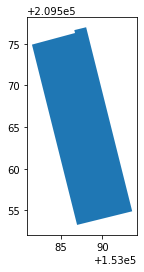

In [123]:


polygon1 = Polygon([(153093.57102139294, 209554.90101145208),
                    (153088.04794938862, 209576.96968346462),
                    (153086.6291333884, 209576.6253634654),
                    (153086.7168133855, 209576.27758746594),
                    (153081.55226938426, 209574.8868674636),
                    (153081.82017338276, 209573.81653146446),
                    (153086.96302139014, 209553.26702744886),
                    (153093.57102139294, 209554.90101145208)])

p = gpd.GeoSeries(polygon1)
p.plot()
plt.show()

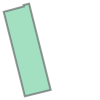

In [125]:
polygon1

### Figure out which tiff file to open depending on the coordinates

To check which tiff file to open, we need to get the boundingbox of the tiff file and then compare if the X and Y of the address is inside the bounding box.

I was able to create a csv file containing the bounding box for all the DSM files. SO we just need to open it and check which tiff file should we use.

In [140]:
coordinates

{'address': 'Sint-Hubertusstraat 89, 2600 Antwerpen',
 'x_value': 153087.56,
 'y_value': 209564.97,
 'latitude': 51.19605343957527,
 'longitude': 4.412926986228825}

In [141]:
bbox = pd.read_csv('data/bounding-box.csv')

In [142]:
bbox.head()

,DSM Files,Left (X),Bottom (Y),Right (X),Top (Y)
0,DSM_1,145000.0,238000.0,162000.0,247000.0
1,DSM_2,162000.0,238000.0,194000.0,250000.0
2,DSM_3,194000.0,238000.0,206000.0,248000.0
3,DSM_4,53000.0,218000.0,66000.0,225500.0
4,DSM_5,66000.0,218000.0,98000.0,232000.0


In [143]:
for i in range(bbox.shape[0]):
    if bbox['Left (X)'][i] <= coordinates['x_value']:
        if bbox['Right (X)'][i] >= coordinates['x_value']:
            if bbox['Bottom (Y)'][i] <= coordinates['y_value']:
                if bbox['Top (Y)'][i] >= coordinates['y_value']:
                    print(coordinates)
                    num = i
                    print(num)
                    break

{'address': 'Sint-Hubertusstraat 89, 2600 Antwerpen', 'x_value': 153087.56, 'y_value': 209564.97, 'latitude': 51.19605343957527, 'longitude': 4.412926986228825}
14


In [144]:
bbox.iloc[num]

DSM Files       DSM_15
Left (X)      130000.0
Bottom (Y)    198000.0
Right (X)     162000.0
Top (Y)       218000.0
Name: 14, dtype: object

Now that we're able to locate from which tiff file the coordinates is located, we can now start using only this specific tiff files.

In [145]:
# Getting the DSM link
if num < 9:
    DSM = f"https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k0{num+1}.zip"
else:
    DSM = f"https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k{num+1}.zip"


In [146]:
# Getting the DTM link
if num < 9:
    DTM = f"https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k0{num+1}.zip"
else:
    DTM = f"https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k{num+1}.zip"

In [147]:
files = {'DSM': DSM, 'DTM': DTM}
files

{'DSM': 'https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k15.zip',
 'DTM': 'https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k15.zip'}

In [22]:
for key, value in files.items():
    with urlopen(value) as zipresp:
        print(f"Downloading the {key} zip file......")
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            print(f"Extracting the {key} zip file .......")
            zfile.extractall(f'data/raster-files/{key}')
            print(f"Done extracting the {key} zip file to raster-files/{key} folder! :)")

Extracting the DSM zip file .......
Done extracting the DSM zip file to raster-files/DSM folder! :)
Extracting the DTM zip file .......
Done extracting the DTM zip file to raster-files/DTM folder! :)


In [ ]:
#This code is only used if we wanted to delete the directory created
#dir_path = 'data/raster-files/DSM'
##os.rmdir(dir_path)

### Creating the Canopy Height Model

Alright! Now the DSM and DTM files are already saved and extracted to the `raster-files` folder.
We can now proceed in creating the <b>Canopy Height Model<b>.

`Canopy Height Model = DSM - DTM`

First, we have to open the tiff file from the extracted files.

In [148]:
#Getting the DSM file
if num < 9:
    DSM_file = f'data/raster-files/DSM/GeoTiff/DHMVIIDSMRAS1m_k0{num+1}.tif'
else:
    DSM_file = f'data/raster-files/DSM/GeoTiff/DHMVIIDSMRAS1m_k{num+1}.tif'  

In [149]:
#Getting the DTM file
if num < 9:
    DTM_file = f'data/raster-files/DTM/GeoTiff/DHMVIIDTMRAS1m_k0{num+1}.tif'
else:
    DTM_file = f'data/raster-files/DTM/GeoTiff/DHMVIIDTMRAS1m_k{num+1}.tif'

In [150]:
DSM_file

'data/raster-files/DSM/GeoTiff/DHMVIIDSMRAS1m_k15.tif'

In [151]:
DTM_file

'data/raster-files/DTM/GeoTiff/DHMVIIDTMRAS1m_k15.tif'

In [8]:
dsm = rt.open(DSM_file)
dsm_array = dsm.read(1) #reading the 1st band
dsm_array

array([[ 4.45,  4.48,  4.47, ..., 11.48, 16.04, 15.43],
       [ 5.72,  4.44,  4.53, ..., 11.51, 16.05, 20.84],
       [ 8.07,  4.47,  4.44, ..., 11.45, 16.46, 22.35],
       ...,
       [ 5.66,  5.59,  5.52, ..., 14.25, 13.04, 10.82],
       [ 5.65,  5.59,  5.52, ..., 11.31, 15.15, 12.76],
       [ 5.69,  5.64,  5.55, ..., 15.15, 10.88, 10.81]], dtype=float32)

In [9]:
dsm_array.size

640000000

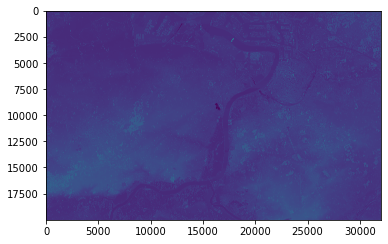

In [10]:
plt.imshow(dsm_array)

In [11]:
dtm = rt.open(DTM_file)
dtm_array = dtm.read(1) #reading the 1st band
dtm_array

array([[ 4.45,  4.48,  4.47, ..., 11.51, 11.48, 11.45],
       [ 4.46,  4.47,  4.55, ..., 11.51, 11.46, 11.45],
       [ 4.45,  4.47,  4.44, ..., 11.45, 11.44, 11.41],
       ...,
       [ 5.66,  5.59,  5.52, ..., 10.85, 10.87, 10.82],
       [ 5.65,  5.59,  5.52, ..., 10.87, 10.9 , 10.81],
       [ 5.69,  5.64,  5.55, ..., 10.85, 10.84, 10.81]], dtype=float32)

In [12]:
dtm_array.size

640000000

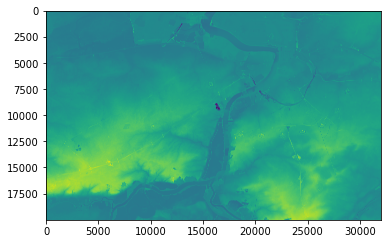

In [13]:
plt.imshow(dtm_array)

Then, we can get the CHM.

In [14]:
chm = dsm_array - dtm_array 
chm

array([[ 0.        ,  0.        ,  0.        , ..., -0.03000069,
         4.5600014 ,  3.9800005 ],
       [ 1.2599998 , -0.02999973, -0.01999998, ...,  0.        ,
         4.589999  ,  9.39      ],
       [ 3.62      ,  0.        ,  0.        , ...,  0.        ,
         5.0199995 , 10.940001  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  3.3999996 ,
         2.17      ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.44000053,
         4.25      ,  1.9499998 ],
       [ 0.        ,  0.        ,  0.        , ...,  4.299999  ,
         0.03999996,  0.        ]], dtype=float32)

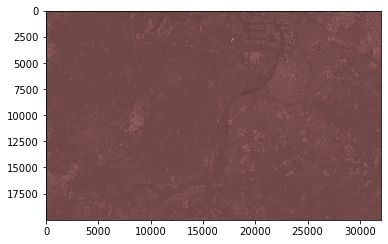

In [15]:
plt.imshow(chm, cmap='pink')
plt.show()

### Plot the coordinates in the CHM

Now that we both have the CHM and the address coordinates with the same crs, we can plot it.

In [152]:
coordinates

{'address': 'Sint-Hubertusstraat 89, 2600 Antwerpen',
 'x_value': 153087.56,
 'y_value': 209564.97,
 'latitude': 51.19605343957527,
 'longitude': 4.412926986228825}

In [156]:
polygon1.coordinates

AttributeError: 'Polygon' object has no attribute 'coordinates'

In [17]:
x = coordinates['x_value']
y = coordinates['y_value']

In [18]:
coor = x,y

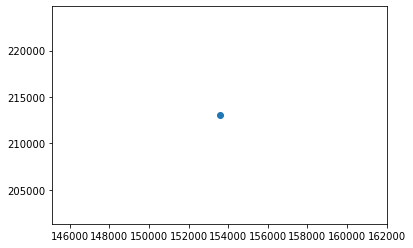

In [19]:
plt.scatter(x,y)

<AxesSubplot:>

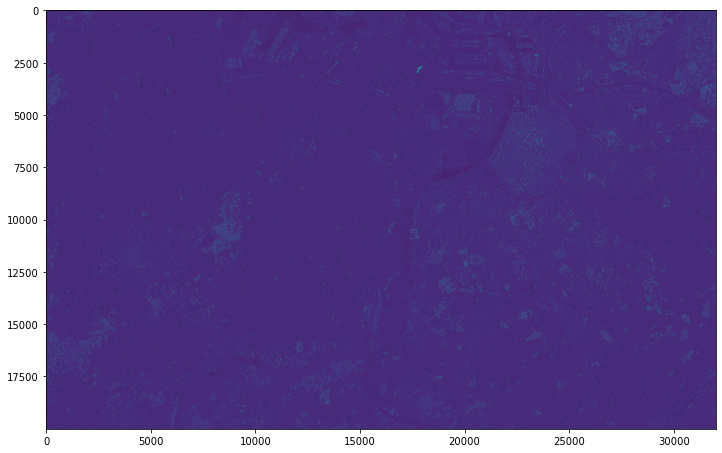

In [20]:
fig, ax = plt.subplots(figsize = (12,12))
plt.scatter(x,y, color='orangered')
show(chm, ax=ax)

### Getting the Geometry (Polygon)

We now need to get the polygon where the coordinates lie using the API from geopunt.be

In [31]:
coordinates = {'address': 'Oranjestraat 23B, 2060 Antwerpen',
 'x_value': 153578.81,
 'y_value': 213055.89,
 'latitude': 51.22742840367053,
 'longitude': 4.419989566014046}

In [32]:
coordinates

{'address': 'Oranjestraat 23B, 2060 Antwerpen',
 'x_value': 153578.81,
 'y_value': 213055.89,
 'latitude': 51.22742840367053,
 'longitude': 4.419989566014046}

In [38]:
path = 'data/Gbg_20210219_15_Shapefile/Shapefile'

In [39]:
polygon = gpd.read_file(path)

In [41]:
polygon.head()

,OIDN,UIDN,VERSIE,BEGINDATUM,VERSDATUM,TYPE,LBLTYPE,OPNDATUM,BGNINV,LBLBGNINV,LENGTE,OPPERVL,geometry
0,697179,738934,1,2009-02-12,2009-02-12,2,bijgebouw,2008-02-14,1,GRB aanmaak,52.61,115.94,"POLYGON ((157863.611 215653.159, 157863.582 21..."
1,401940,442949,1,2008-05-30,2008-05-30,1,hoofdgebouw,2007-01-29,1,GRB aanmaak,37.34,85.99,"POLYGON ((146702.694 212259.883, 146698.232 21..."
2,626770,668236,1,2009-01-19,2009-01-19,1,hoofdgebouw,2007-07-30,1,GRB aanmaak,74.66,226.80,"POLYGON ((161819.873 214216.388, 161814.704 21..."
3,820454,862246,1,2009-04-07,2009-04-07,2,bijgebouw,2008-07-02,1,GRB aanmaak,29.79,45.05,"POLYGON ((138439.477 201851.832, 138441.043 20..."
4,699200,740955,1,2009-02-12,2009-02-12,1,hoofdgebouw,2008-02-14,1,GRB aanmaak,37.40,78.83,"POLYGON ((156404.746 214769.266, 156401.007 21..."


In [51]:
coordinates['x_value'], coordinates['y_value']


(153578.81, 213055.89)

In [53]:
polygon.shape

(441377, 13)

In [50]:
building = ppolygon.bounds.minx < coordinates['x_value']]

,OIDN,UIDN,VERSIE,BEGINDATUM,VERSDATUM,TYPE,LBLTYPE,OPNDATUM,BGNINV,LBLBGNINV,LENGTE,OPPERVL,geometry
0,697179,738934,1,2009-02-12,2009-02-12,2,bijgebouw,2008-02-14,1,GRB aanmaak,52.61,115.94,"POLYGON ((157863.611 215653.159, 157863.582 21..."
1,401940,442949,1,2008-05-30,2008-05-30,1,hoofdgebouw,2007-01-29,1,GRB aanmaak,37.34,85.99,"POLYGON ((146702.694 212259.883, 146698.232 21..."
2,626770,668236,1,2009-01-19,2009-01-19,1,hoofdgebouw,2007-07-30,1,GRB aanmaak,74.66,226.80,"POLYGON ((161819.873 214216.388, 161814.704 21..."
3,820454,862246,1,2009-04-07,2009-04-07,2,bijgebouw,2008-07-02,1,GRB aanmaak,29.79,45.05,"POLYGON ((138439.477 201851.832, 138441.043 20..."
4,699200,740955,1,2009-02-12,2009-02-12,1,hoofdgebouw,2008-02-14,1,GRB aanmaak,37.40,78.83,"POLYGON ((156404.746 214769.266, 156401.007 21..."


In [ ]:
205001 address id

In [62]:
address_api = requests.get("https://api.Basisregisters.vlaanderen.be/v1/addresses/<'index' : '205001'>")

In [63]:
address_api

<Response [403]>